c:\Users\cjogi\AppData\Local\pypoetry\Cache\virtualenvs\atd-walker-package-VDrAW----py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded policy from Calum_Testing/ddpg_batch.pth. Expected input dim: 17
Background data shape (raw): (200, 17)
Summarizing background data using kmeans...
Background summary shape: (50, 17)
Creating unified SHAP explainer...
States to explain shape: (50, 17)
Computing SHAP values...
SHAP values computed. Their shape is: (50, 17, 6)
SHAP Summary Plot for Action Dimension 0


C:\Users\cjogi\AppData\Local\Temp\ipykernel_21960\280069448.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)


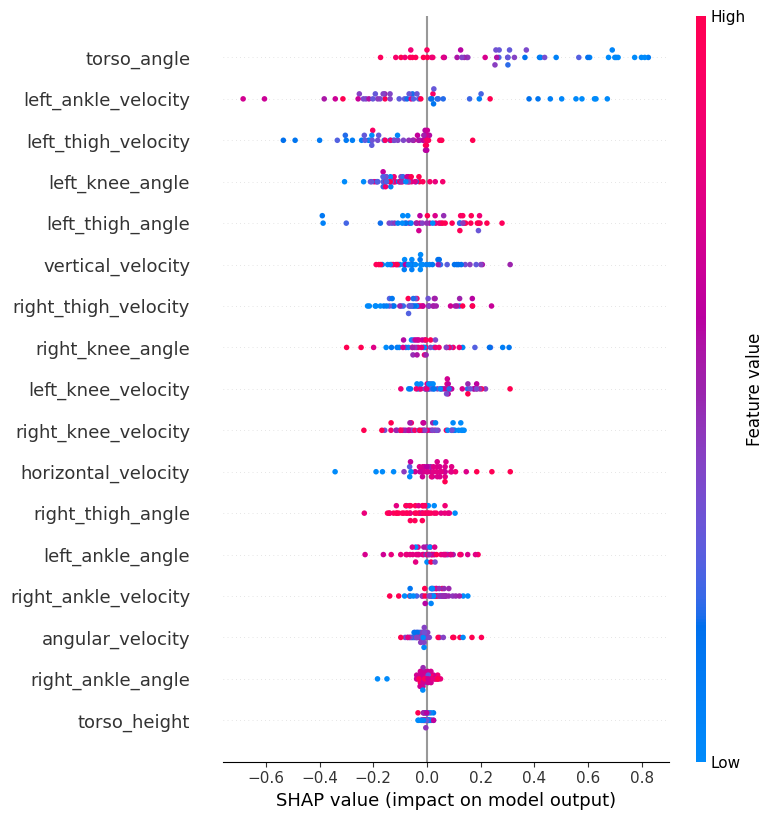

SHAP Summary Plot for Action Dimension 1


C:\Users\cjogi\AppData\Local\Temp\ipykernel_21960\280069448.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)


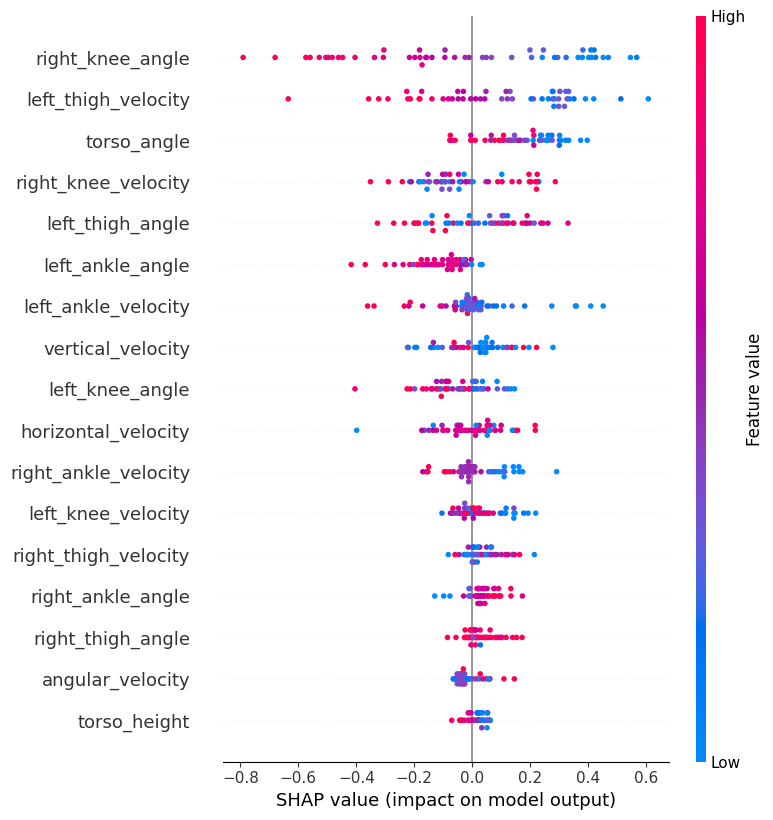

SHAP Summary Plot for Action Dimension 2


C:\Users\cjogi\AppData\Local\Temp\ipykernel_21960\280069448.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)


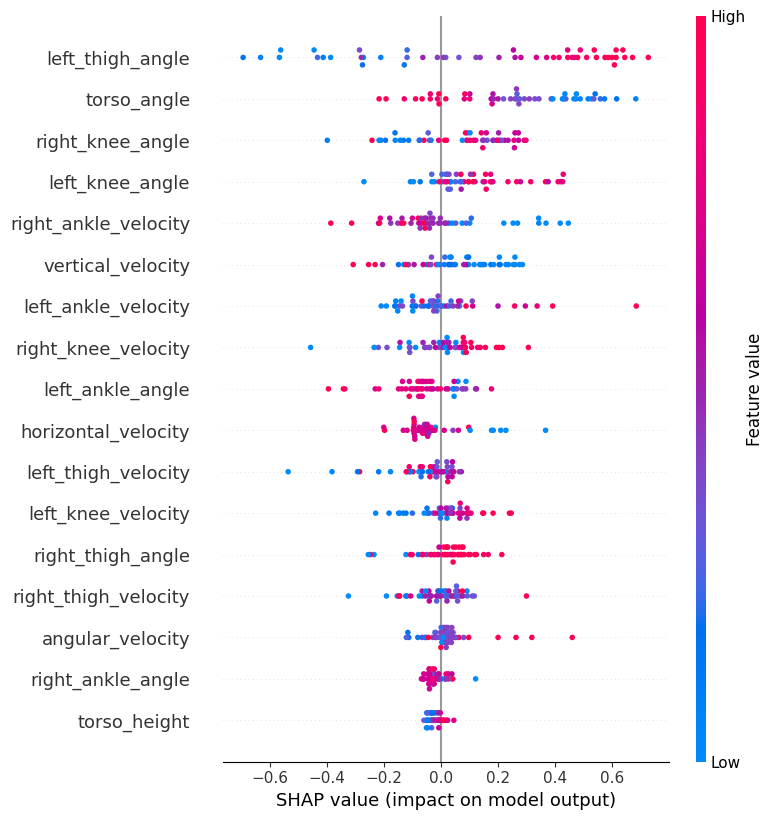

SHAP Summary Plot for Action Dimension 3


C:\Users\cjogi\AppData\Local\Temp\ipykernel_21960\280069448.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)


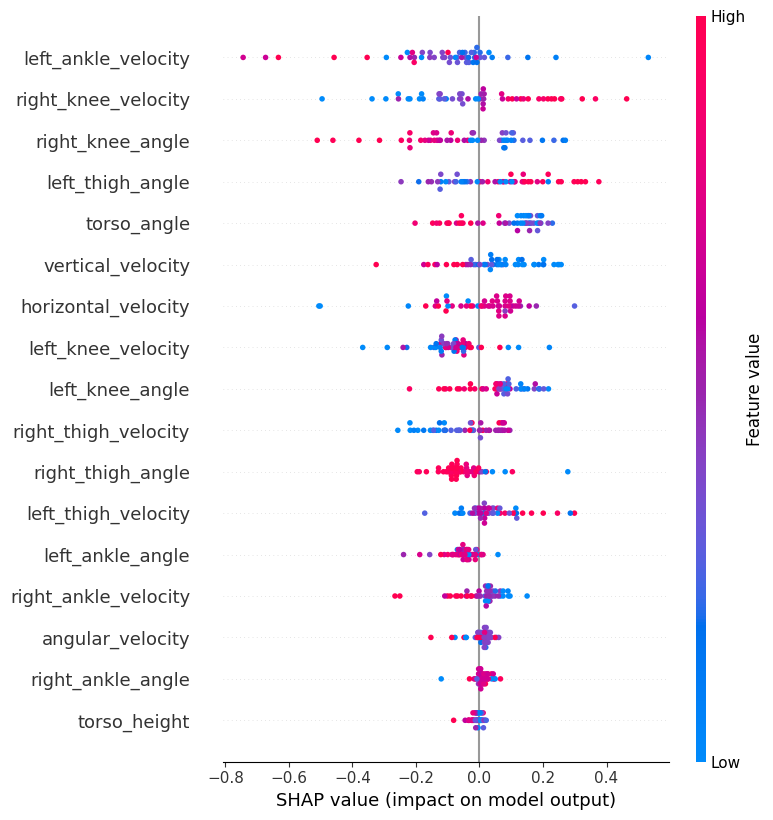

SHAP Summary Plot for Action Dimension 4


C:\Users\cjogi\AppData\Local\Temp\ipykernel_21960\280069448.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)


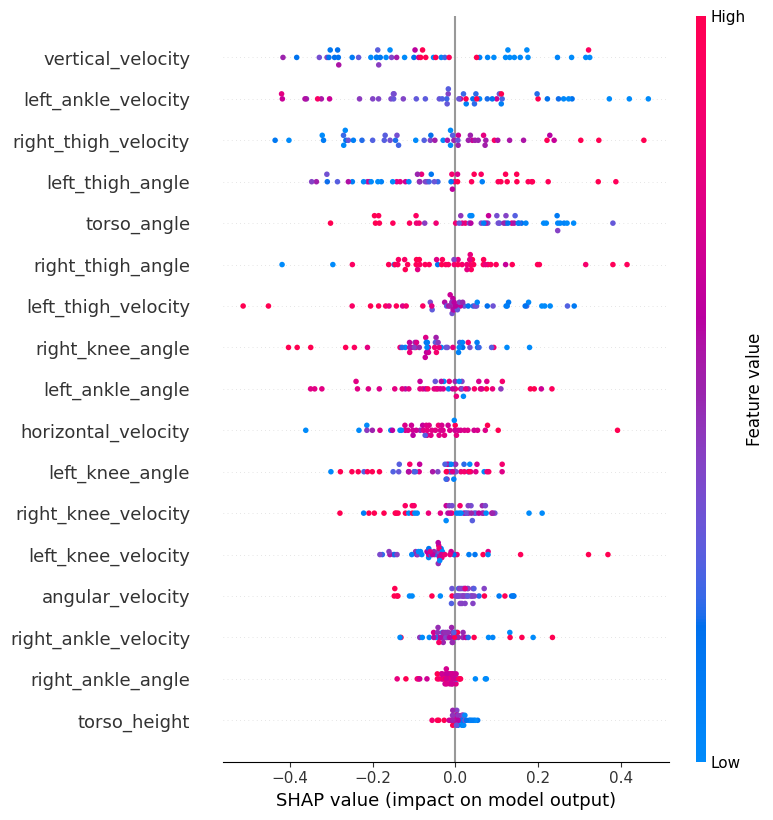

SHAP Summary Plot for Action Dimension 5


C:\Users\cjogi\AppData\Local\Temp\ipykernel_21960\280069448.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)


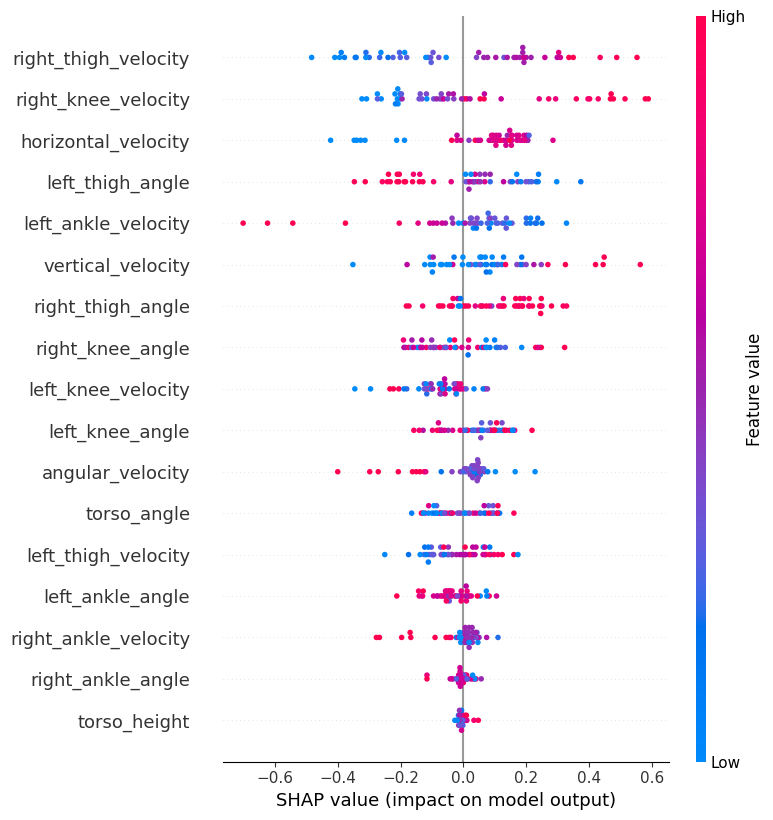

In [1]:
#!/usr/bin/env python
import os
import argparse
import numpy as np
import torch
import gymnasium as gym
import shap

# Local imports from your project
from algorithms.common import PolicyNetwork, DEFAULT_DEVICE, ACTION_DIM, STATE_DIM

def load_policy(policy_path="Calum_Testing/ddpg_batch.pth"):
    """Load a trained policy from a checkpoint file."""
    policy = PolicyNetwork().to(DEFAULT_DEVICE)
    policy.load_state_dict(torch.load(policy_path, map_location=DEFAULT_DEVICE))
    policy.eval()
    print(f"Loaded policy from {policy_path}. Expected input dim: {policy.fc1.in_features}")
    return policy

def init_env():
    """Initialize the Walker2d environment (v5) with rendered RGB arrays."""
    env = gym.make("Walker2d-v5", render_mode="rgb_array")
    return env

def collect_states_random(env, num_samples=500):
    """Collect states by executing random actions."""
    states = []
    observation, _ = env.reset()
    for _ in range(num_samples):
        states.append(observation)
        action = env.action_space.sample()
        observation, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            observation, _ = env.reset()
    return np.array(states)

def collect_states_on_policy(env, policy, num_samples=500):
    """Collect states from running the trained policy (on-policy)."""
    states = []
    observation, _ = env.reset()
    for _ in range(num_samples):
        states.append(observation)
        obs_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(DEFAULT_DEVICE)
        with torch.no_grad():
            action = policy(obs_tensor).cpu().numpy()[0]
        observation, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            observation, _ = env.reset()
    return np.array(states)

def wrapped_policy(x, policy):
    """
    A wrapper function that converts numpy inputs to torch tensors, feeds them through the policy,
    and converts the outputs back to a numpy array.
    """
    # x is a numpy array of shape (n_samples, STATE_DIM)
    x_tensor = torch.tensor(x, dtype=torch.float32).to(DEFAULT_DEVICE)
    with torch.no_grad():
        # The policy outputs a tensor of shape (n_samples, ACTION_DIM)
        out = policy(x_tensor)
    return out.detach().cpu().numpy()

def run_shap_analysis(policy, env, bg_data_collection="on_policy",
                      num_bg_samples=200, num_explain_samples=50):
    # Collect background data
    if bg_data_collection == "on_policy":
        print("Collecting on-policy background data...")
        background_data = collect_states_on_policy(env, policy, num_samples=num_bg_samples)
    else:
        print("Collecting random background data...")
        background_data = collect_states_random(env, num_samples=num_bg_samples)
        
    print("Background data shape (raw):", background_data.shape)
    
    # Summarize the background data using kmeans to reduce runtime.
    print("Summarizing background data using kmeans...")
    background_summary = shap.kmeans(background_data, 50)
    # Access the underlying numpy array from the DenseData object:
    background_summary_array = background_summary.data
    print("Background summary shape:", background_summary_array.shape)
    
    # Create a wrapped version of the policy function so that inputs are properly converted.
    wrapped_fn = lambda x: wrapped_policy(x, policy)
    
    # Use the unified SHAP API by passing the wrapped function and the summarized background.
    print("Creating unified SHAP explainer...")
    explainer = shap.Explainer(wrapped_fn, background_summary_array)
    
    # Collect states to explain (using on-policy data).
    states_to_explain = collect_states_on_policy(env, policy, num_samples=num_explain_samples)
    print("States to explain shape:", states_to_explain.shape)
    
    # Compute SHAP values for the states.
    print("Computing SHAP values...")
    shap_values = explainer(states_to_explain)
    # For a vector-valued model with ACTION_DIM outputs, shap_values.values should have shape:
    #   (num_explain_samples, STATE_DIM, ACTION_DIM)
    print("SHAP values computed. Their shape is:", shap_values.values.shape)
    
    # Define feature names for the 17-dimensional observation.
    if STATE_DIM == 17:
        feature_names = [
            "torso_height", "torso_angle", "left_thigh_angle", "left_knee_angle", "left_ankle_angle",
            "right_thigh_angle", "right_knee_angle", "right_ankle_angle", "left_thigh_velocity", 
            "left_knee_velocity", "left_ankle_velocity", "right_thigh_velocity", "right_knee_velocity",
            "right_ankle_velocity", "horizontal_velocity", "vertical_velocity", "angular_velocity"
        ]
    else:
        feature_names = [f"feature_{i}" for i in range(STATE_DIM)]
    
    # Visualize SHAP summary for each action dimension.
    for action_idx in range(ACTION_DIM):
        print(f"SHAP Summary Plot for Action Dimension {action_idx}")
        # Extract the SHAP values for the current action dimension.
        # Expected shape: (num_explain_samples, STATE_DIM)
        action_shap = shap_values.values[:, :, action_idx]
        shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)
    
    return shap_values

def main():
    parser = argparse.ArgumentParser(description="Unified SHAP Analysis for TD3 on Walker2d")
    parser.add_argument("--explainer", type=str, default="unified",
                        choices=["unified", "kernel", "deep"],
                        help="Type of SHAP explainer to use (currently using unified API by default)")
    parser.add_argument("--bg", type=str, default="on_policy",
                        choices=["on_policy", "random"],
                        help="Background data collection method")
    parser.add_argument("--num_bg", type=int, default=200,
                        help="Number of background samples")
    parser.add_argument("--num_explain", type=int, default=50,
                        help="Number of samples to explain")
    parser.add_argument("--policy_path", type=str, default="Calum_Testing/ddpg_batch.pth",
                        help="Path to the policy checkpoint file")
    args, unknown = parser.parse_known_args()
    
    policy = load_policy(args.policy_path)
    env = init_env()
    run_shap_analysis(policy, env, bg_data_collection=args.bg, 
                      num_bg_samples=args.num_bg, num_explain_samples=args.num_explain)

if __name__ == "__main__":
    main()
